In [1]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments, \
BertForQuestionAnswering, DistilBertForTokenClassification, AutoTokenizer, AutoModel, AutoModelForTokenClassification

from nlp import load_dataset, Dataset
import torch
from transformers import pipeline
import numpy as np
import pandas as pd
from transformers import DistilBertForTokenClassification


# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Quick Examples using the pipeline object in transformers

We can run some quick examples of fine-tuned models using the nlp module in the transformers package

In [2]:
# list of available pipelines here: https://huggingface.co/transformers/main_classes/pipelines.html
nlp = pipeline("question-answering")

print(type(nlp.model))  # Using a flavor of BERT called DistilBERT

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForQuestionAnswering'>


In [3]:
context = "My friend Walker owns a Tarantula. I, Sinan, own a dog. Matt just got a cat!"

print(nlp(question="What kind of pet does Sinan have?", context=context))  # should be dog
print(nlp(question="What kind of pet does Matt have?", context=context))  # should be cat

{'score': 0.7949583530426025, 'start': 51, 'end': 54, 'answer': 'dog'}
{'score': 0.7224200963973999, 'start': 72, 'end': 75, 'answer': 'cat'}


In [4]:
# A sentiment analysis pipeline
nlp = pipeline("sentiment-analysis")

print(type(nlp.model))  # Using a flavor of BERT called DistilBERT

print(nlp("My friend told me about this class and I love it so far! She was right."))

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>
[{'label': 'POSITIVE', 'score': 0.9998711347579956}]


In [5]:
# We can even do a auto-encoder languuage model task!

nlp = pipeline("fill-mask")

print(type(nlp.model))  # Using a flavor of BERT called RoBERTa

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")
print('If you don’t *** at the sign, you will get a ticket')
for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

<class 'transformers.models.roberta.modeling_roberta.RobertaForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token: stop. Score: 42.11%
Token: look. Score: 7.53%
Token: park. Score: 4.92%
Token: arrive. Score: 4.65%
Token: sign. Score: 4.27%


# Example 1: Sequence Classification

![BERT Sequence Classification](images/bert_seq_class.png)

In [6]:
# Ingest 100 tweets with the token $tsla in them

tsla_tweets = pd.read_csv('./data/tsla.csv')

tsla_tweets.head(2)

,sentiment,text,user
0,positive,RT @rs_financial: **TESLA GIVEAWAY** \n\nWe ar...,MichaelEvEllis
1,positive,RT @The_Real_Fly: Elon is 100% fucking $TSLA w...,mates_cheers


In [7]:
# check our tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

first_tweet = tsla_tweets['text'][0]

tokens = tokenizer.encode(first_tweet)

print(f'Tweet: {first_tweet}. Num tokens: {len(tokens)}')
for t in tokens:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')

Tweet: RT @rs_financial: **TESLA GIVEAWAY** \n\nWe are giving away one $TSLA share for FREE (equivalent cash value) to one person that retweets this…. Num tokens: 45
Token: 101, subword: [CLS]
Token: 19387, subword: rt
Token: 1030, subword: @
Token: 12667, subword: rs
Token: 1035, subword: _
Token: 3361, subword: financial
Token: 1024, subword: :
Token: 1008, subword: *
Token: 1008, subword: *
Token: 26060, subword: tesla
Token: 2507, subword: give
Token: 9497, subword: ##away
Token: 1008, subword: *
Token: 1008, subword: *
Token: 1032, subword: \
Token: 1050, subword: n
Token: 1032, subword: \
Token: 22064, subword: nw
Token: 2063, subword: ##e
Token: 2024, subword: are
Token: 3228, subword: giving
Token: 2185, subword: away
Token: 2028, subword: one
Token: 1002, subword: $
Token: 24529, subword: ts
Token: 2721, subword: ##la
Token: 3745, subword: share
Token: 2005, subword: for
Token: 2489, subword: free
Token: 1006, subword: (
Token: 5662, subword: equivalent
Token: 5356, subword: c

In [8]:
tsla_tweets['sentiment'].value_counts()

neutral     48
positive    34
negative    18
Name: sentiment, dtype: int64

In [9]:
# Let's map our sentiment to a numerical classes. neutral and negative -> 0, neutral -> 1, and positive -> 2

tsla_tweets['sentiment'] = tsla_tweets['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [10]:
# the trainer is expecting a 'label' (see the forward method in the docs)
tsla_tweets['label'] = tsla_tweets['sentiment']

tsla_tweets['label'].value_counts()

1    48
2    34
0    18
Name: label, dtype: int64

In [11]:
tweet_dataset = Dataset.from_pandas(tsla_tweets)

In [12]:
type(tweet_dataset)

nlp.arrow_dataset.Dataset

In [13]:
# Dataset has a built in train test split method

tweet_dataset = tweet_dataset.train_test_split(test_size=0.3)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

In [15]:
sequence_classification_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=3)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Let's break down this warning:

```
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
```

This is telling us about the weights that it is not using in this sequence classification version of BERT

--

```
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

The `classifier.weight` and `classifier.bias` are two new matrices we need to learn during fine-tuning

In [16]:
type(sequence_classification_model.bert)  # normal BERT model

transformers.models.bert.modeling_bert.BertModel

In [17]:
# this classifier is a feed forward layer that is shared across tokens. It squashes the BERT's 768 dimension
# into 3 dimensions (negative, neutral, positive)

print(sequence_classification_model.classifier.weight.shape)

print(sequence_classification_model.classifier.bias.shape)

torch.Size([3, 768])
torch.Size([3])


In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [19]:
train_set[0]

{'label': 1,
 'sentiment': 1,
 'text': 'Buy $BTC sell $TSLA',
 'user': 'CryptoChaine'}

In [20]:
tweet = '$TSLA is going up like crazy'
print(tweet)

encodings = tokenizer.encode_plus(tweet)

# token_ids, attentionMask = encodings["input_ids"], encodings["attention_mask"]

token_ids = torch.tensor(encodings['input_ids']).unsqueeze(0)
attention_mask = torch.tensor(encodings['attention_mask']).unsqueeze(0)

pre_finetuning_response = sequence_classification_model(
    token_ids, output_hidden_states=True
)

pre_finetuning_response.hidden_states[0]

$TSLA is going up like crazy


tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [-0.1050,  0.1661, -0.9914,  ...,  0.2027,  0.6734,  0.2520],
         [ 0.3767, -0.6897, -0.1829,  ..., -0.6494,  0.1278,  0.4465],
         ...,
         [ 0.3810,  0.4720,  0.4045,  ...,  0.1828,  1.0139,  0.2938],
         [-0.2988, -0.8134,  0.2842,  ...,  0.8991,  0.1088, -1.0871],
         [-0.1474, -0.0411, -0.0732,  ..., -0.1157,  0.0421, -0.0550]]],
       grad_fn=<NativeLayerNormBackward>)

In [21]:
pre_finetuning_response.logits

tensor([[ 0.1706, -0.0231, -0.2510]], grad_fn=<AddmmBackward>)

In [22]:
# We will pad our dataset so that our input matrices are the same length and truncate anything longer than 512 tokens
def preprocess(data):
    return tokenizer(data['text'], padding=True, truncation=True)

In [23]:
train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_set.set_format('torch', 
                      columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', 
                     columns=['input_ids', 'attention_mask', 'label'])

In [25]:
batch_size = 8
epochs = 2

warmup_steps = 500
weight_decay = 0.01

In [26]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    logging_dir='./logs',
)
# Define the trainer: 

trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set
)

# Get initial metrics
trainer.evaluate()

{'eval_loss': 1.0968059301376343,
 'eval_runtime': 4.3494,
 'eval_samples_per_second': 6.897}

In [27]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=18, training_loss=1.1496016184488933, metrics={'train_runtime': 81.0922, 'train_samples_per_second': 0.222, 'total_flos': 8736866850600.0, 'epoch': 2.0})

In [28]:
trainer.evaluate()

{'eval_loss': 1.0894685983657837,
 'eval_runtime': 4.2495,
 'eval_samples_per_second': 7.06,
 'epoch': 2.0}

In [29]:
print(tweet)

post_finetuning_response = sequence_classification_model(
    token_ids, output_hidden_states=True
)

# hidden states are different from before fine tuning
(post_finetuning_response.hidden_states[0] == pre_finetuning_response.hidden_states[0]).all()

$TSLA is going up like crazy


tensor(False)

In [30]:
post_finetuning_response.hidden_states[0]

tensor([[[ 0.1685, -0.2856, -0.3261,  ..., -0.0276,  0.0382,  0.1640],
         [-0.1049,  0.1664, -0.9915,  ...,  0.2026,  0.6733,  0.2519],
         [ 0.3767, -0.6894, -0.1830,  ..., -0.6493,  0.1278,  0.4463],
         ...,
         [ 0.3809,  0.4722,  0.4043,  ...,  0.1828,  1.0139,  0.2936],
         [-0.2986, -0.8132,  0.2840,  ...,  0.8990,  0.1088, -1.0872],
         [-0.1473, -0.0410, -0.0731,  ..., -0.1159,  0.0421, -0.0551]]],
       grad_fn=<NativeLayerNormBackward>)

In [31]:
post_finetuning_response.logits

tensor([[ 0.1423, -0.0080, -0.2226]], grad_fn=<AddmmBackward>)

Let's try that sequence again but this time, let's freeze the layers of BERT to try and speed up training

In [32]:
# re-instantiate BERT
new_sequence_classification_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=3
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [33]:
# freeze all layers in BERT to speed up training
for param in new_sequence_classification_model.bert.parameters():
    param.requires_grad = False  # disable training in BERT

In [34]:
# Change the model in the trainer to be our newly instantiated model
trainer = Trainer(
    model=new_sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set
)

# Get initial metrics. Similar as before. Check: Why isn't it the same loss?
trainer.evaluate()

{'eval_loss': 1.3576469421386719,
 'eval_runtime': 4.2398,
 'eval_samples_per_second': 7.076}

In [35]:
trainer.train()  # MUCH faster

Step,Training Loss


TrainOutput(global_step=18, training_loss=1.1115553114149306, metrics={'train_runtime': 23.1385, 'train_samples_per_second': 0.778, 'total_flos': 8736866850600.0, 'epoch': 2.0})

In [36]:
trainer.evaluate()

{'eval_loss': 1.3554033041000366,
 'eval_runtime': 4.2576,
 'eval_samples_per_second': 7.046,
 'epoch': 2.0}

In [37]:
post_finetuning_response = new_sequence_classification_model(
    token_ids, output_hidden_states=True
)

# hidden states are same as before fine tuning
(post_finetuning_response.hidden_states[0] == pre_finetuning_response.hidden_states[0]).all()

tensor(True)

In [38]:
# the logits are different as the pre-trained model because the classifier weights are initialized randomly every time
#  this is also why the initial logits weren't the same

pre_finetuning_response.logits, post_finetuning_response.logits  

(tensor([[ 0.1706, -0.0231, -0.2510]], grad_fn=<AddmmBackward>),
 tensor([[-0.5157, -0.2191,  0.3199]], grad_fn=<AddmmBackward>))

In [39]:
post_finetuning_response.hidden_states[0]

tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [-0.1050,  0.1661, -0.9914,  ...,  0.2027,  0.6734,  0.2520],
         [ 0.3767, -0.6897, -0.1829,  ..., -0.6494,  0.1278,  0.4465],
         ...,
         [ 0.3810,  0.4720,  0.4045,  ...,  0.1828,  1.0139,  0.2938],
         [-0.2988, -0.8134,  0.2842,  ...,  0.8991,  0.1088, -1.0871],
         [-0.1474, -0.0411, -0.0732,  ..., -0.1157,  0.0421, -0.0550]]])

# Example 2. Question/Answering with a model already fine-tuned using SQuAD


![BERT QA](images/bert_qa.png)

In [40]:
# there are pre fine-tuned models that learned from the SQuAD dataset

large_bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', return_token_type_ids=True)
qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [41]:
type(qa_bert.bert)  # BERT model

transformers.models.bert.modeling_bert.BertModel

In [42]:
print(f'number of layers in the encoder stack: {len(qa_bert.bert.encoder.layer)}')  #  LARGE BERT

number of layers in the encoder stack: 24


### Count the Parameters in Large BERT

In [43]:
total_params = 0
for p in qa_bert.bert.parameters():
    if len(p.shape) == 2:
        total_params += p.shape[0] * p.shape[1]
        
print(f'Total Parameters: {total_params:,}')  # This is where the 110M parameter comes from

Total Parameters: 333,770,752


In [44]:
# Get all of the model's parameters as a list of tuples.
params = list(qa_bert.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 391 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [45]:
# this qa_outputs is a feed forward layer that is shared across tokens. It squashes the BERT-large's 1024 dimension
# into 2 dimensions (start position and end position)

In [46]:
sns.set(rc={"figure.figsize":(20, 5)}) 

def q_a(question, context):
    encodings = large_bert_tokenizer.encode_plus(question, context)

    inputIds, attentionMask = encodings["input_ids"], encodings["attention_mask"]

    response = qa_bert(torch.tensor([inputIds]), attention_mask=torch.tensor([attentionMask]))
    scoresStart, scoresEnd = response['start_logits'], response['end_logits']
    tokens = inputIds[torch.argmax(scoresStart): torch.argmax(scoresEnd) + 1]
    answerTokens = large_bert_tokenizer.convert_ids_to_tokens(tokens, skip_special_tokens=True)
    
    token_labels = large_bert_tokenizer.convert_ids_to_tokens(inputIds)
    
    
    # bar plot code courtesy of Chris McCormick
    # https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
    
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=token_labels, y=scoresStart.squeeze().tolist(), ci=None)
    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    # Turn on the vertical grid to help align words to scores.
    plt.title('Start Word Scores')
    
    plt.show()
    
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=token_labels, y=scoresEnd.squeeze().tolist(), ci=None)
    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    # Turn on thaae vertical grid to help align words to scores.
    plt.title('End Word Scores')

    plt.show()
    
    
    return large_bert_tokenizer.convert_tokens_to_string(answerTokens)

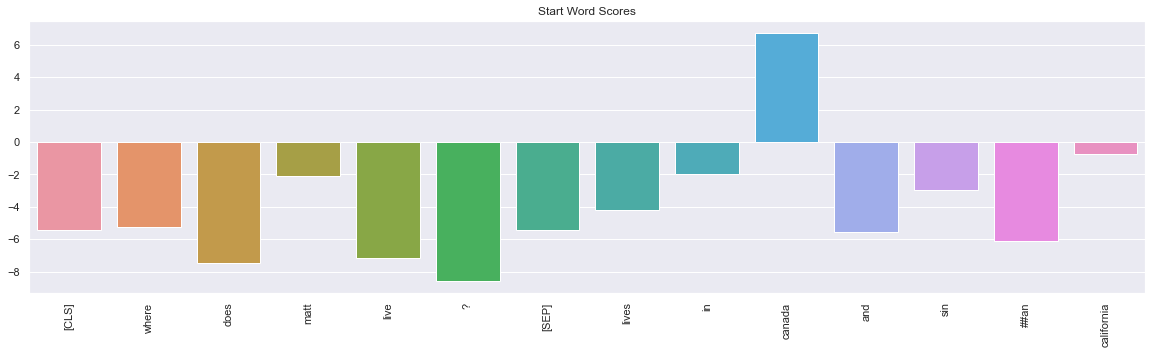

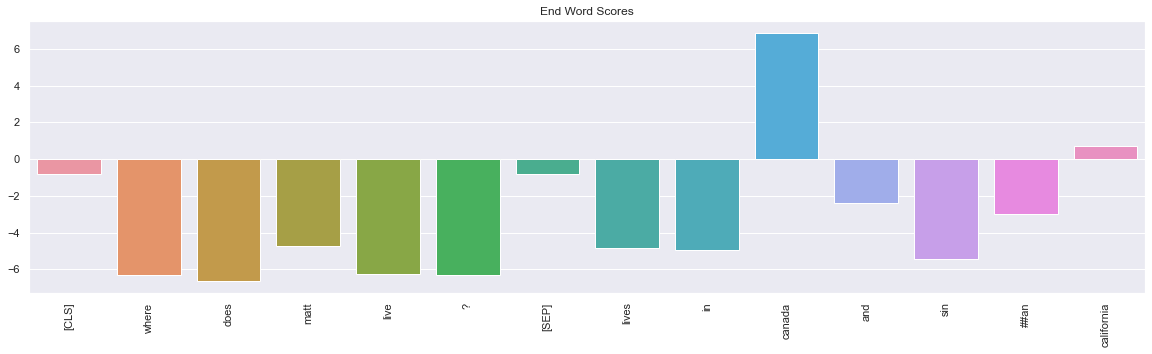

'canada'

In [47]:
q_a("Where does Matt live?", "Matt lives in Canada and Sinan lives in California")

In [48]:
# From https://docs.microsoft.com/en-us/azure/databricks/kb/jobs/active-vs-dead-jobs

longer_context = """
Whenever there are too many concurrent jobs running on a cluster, there is a chance that the Spark internal 
eventListenerBus drops events. These events are used to track job progress in the Spark UI. Whenever the event 
listener drops events you start seeing dead jobs/stages in Spark UI, which never finish. 
The jobs are actually finished but not shown as completed in the Spark UI.
"""

In [49]:
print(len(tokenizer(longer_context)['input_ids']))  # 78 tokens
      
for t in tokenizer(longer_context)['input_ids'][:30]:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')
    


78
Token: 101, subword: [CLS]
Token: 7188, subword: whenever
Token: 2045, subword: there
Token: 2024, subword: are
Token: 2205, subword: too
Token: 2116, subword: many
Token: 16483, subword: concurrent
Token: 5841, subword: jobs
Token: 2770, subword: running
Token: 2006, subword: on
Token: 1037, subword: a
Token: 9324, subword: cluster
Token: 1010, subword: ,
Token: 2045, subword: there
Token: 2003, subword: is
Token: 1037, subword: a
Token: 3382, subword: chance
Token: 2008, subword: that
Token: 1996, subword: the
Token: 12125, subword: spark
Token: 4722, subword: internal
Token: 2724, subword: event
Token: 9863, subword: ##list
Token: 24454, subword: ##ener
Token: 8286, subword: ##bus
Token: 9010, subword: drops
Token: 2824, subword: events
Token: 1012, subword: .
Token: 2122, subword: these
Token: 2824, subword: events


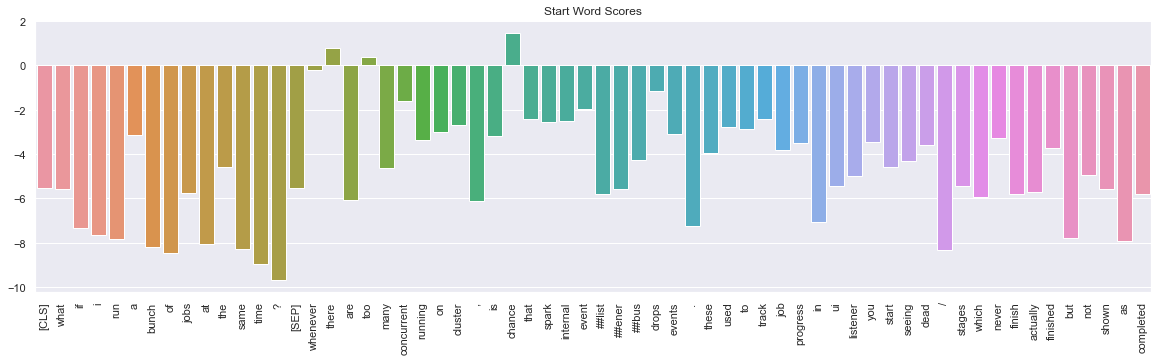

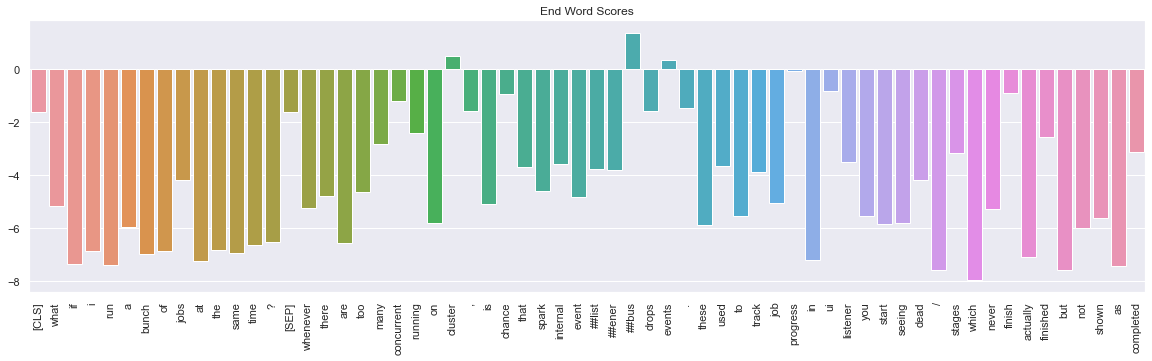

'there is a chance that the spark internal eventlistenerbus drops events'

In [50]:
q_a("what if I run a bunch of jobs at the same time?", longer_context)

# Working with flavors of BERT

In [51]:
distil_model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased')


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

In [52]:
type(distil_model)

transformers.models.distilbert.modeling_distilbert.DistilBertForTokenClassification

In [53]:
# Get all of the model's parameters as a list of tuples.
named_params = list(distil_model.named_parameters())

print('The DistilBERT model has {:} different named parameters.\n'.format(len(named_params)))

print('==== Embedding Layer ====\n')
for p in named_params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')
for p in named_params[5:20]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')
for p in named_params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The DistilBERT model has 102 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (30522, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight           (768,)
distilbert.transformer.layer.0.sa_layer_norm.bias        

# Count the Parameters in DistilBERT

In [54]:
total_params = 0
for p in distil_model.parameters():
    if len(p.shape) == 2:
        total_params += p.shape[0] * p.shape[1]
        
print(f'Total Parameters: {total_params:,}')  # This is where the 110M parameter comes from

Total Parameters: 66,302,976


![Transformers](images/hf_models.png)

In [55]:
# https://huggingface.co/savasy/bert-base-turkish-ner-cased
custom_module = 'savasy/bert-base-turkish-ner-cased'

turkish_ner_tokenizer = AutoTokenizer.from_pretrained(custom_module)
turkish_ner_model = AutoModelForTokenClassification.from_pretrained(custom_module)

In [56]:
type(turkish_ner_model.bert)  # standard BERT

transformers.models.bert.modeling_bert.BertModel

In [57]:
sequence = "Merhaba! Benim adım Sinan. San Francisco'dan geliyorum" # Hi! I'm Sinan. I come from San Francisco

In [58]:
ner=pipeline('ner', model=turkish_ner_model, tokenizer=turkish_ner_tokenizer)
ner(sequence)

[{'word': 'Sinan',
  'score': 0.7242471575737,
  'entity': 'B-PER',
  'index': 5,
  'start': 20,
  'end': 25},
 {'word': 'San',
  'score': 0.9987995624542236,
  'entity': 'B-LOC',
  'index': 7,
  'start': 27,
  'end': 30},
 {'word': 'Francisco',
  'score': 0.9977098107337952,
  'entity': 'I-LOC',
  'index': 8,
  'start': 31,
  'end': 40}]